# Workbook for testing and documenting the Python Algorithms
> After finalizign algorithm here, it will be added to the main project under streamlit so it runs natively on the backend

In [8]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
from time import time
from datetime import datetime, timedelta, timezone
from functools import wraps, lru_cache
import collections
import matplotlib.pyplot as plt

In [9]:
def calc_runtime(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time()
        result = func(*args, **kwargs)
        end_time = time()
        print(f"{func.__name__}({args, kwargs}) executed in ", end="")
        print(f"{end_time - start_time:.6f} seconds")
        return result
    return wrapper

# Initialize input data

In [10]:
S0 = 100.0     # Initial Stock Price
K = 120.0      # Strike Price
r = 0.06      # Risk-free interest rate
T = 5          # Time to maturity in years
N = 2000        # Number of time steps
vol = 0.2      # Volatility of the underlying stock (user input)
opttype = "C"  # "C" for Call, "P" for Put  
optclass = "E" # European or American option


# CRR values
### Calculating the up (up) and down (d) values using volatility (σ)

## CRR using infered σ from u and d

In [11]:
# u and d inferered from CRR model

## CRR using implied σ
> found by reverse calculating σ from option market price

In [12]:
# connect too Yahoo Finance to get stock/option data
def implied_volatility(symbol, S0, K, r, T, market_price, opttype):
    # Function to calculate implied volatility
    pass  # Implementation goes here

def crr_up_down(vol, dt):
    u = np.exp(vol * np.sqrt(dt))
    d = 1 / u
    return u, d

# Binmoial Method Algorithm

### Python Dynamic Programming

In [13]:
@calc_runtime
def binomial_option_price_dp(S0, K, T, r, N, u, d, opttype='C', optclass="E") -> float:
    """
    This algorithm uses dynamic programming to store option values at each node,
    iteratively calculating values from maturity back to the present.

    Only stores one layer of option values at a time to optimize space.

    Complexity:
    Time: O(N^2)
    Space: O(N)
    """

    dt = T / N
    q = (np.exp(r * dt) - d) / (u - d) # risk-neutral probability
    print(q)
    discount = np.exp(-r * dt)

    # Initialize asset prices at maturity
    S = np.zeros(N + 1) # [0, 0, .. N]
    S[0] = S0 * (d ** N) # [S0, 0, .. N]

    # Build the asset price tree
    for up_move in range(1, N+1):
        # Going up the tree
        S[up_move] = S[up_move - 1] * (u / d)

    # Initialize option values at maturity
    option_values = np.zeros(N + 1) # [0, 0, .. N]
    for up_move in range(N + 1):
        if opttype == 'C':
            option_values[up_move] = max(0, S[up_move] - K)
        else:
            option_values[up_move] = max(0, K - S[up_move])

    # Backward induction
    for step in range(N - 1, -1, -1):
        for up_move in range(step + 1):
            option_values[up_move] = discount * (q * option_values[up_move + 1] + (1 - q) * option_values[up_move]) # binomial formula
            if optclass == "A":
                # American option early exercise check
                if opttype == 'C':
                    option_values[up_move] = max(
                        option_values[up_move], 
                        S0 * (u ** up_move) * (d ** (step - up_move)) - K
                        )
                else:
                    option_values[up_move] = max(
                        option_values[up_move], 
                        K - S0 * (u ** up_move) * (d ** (step - up_move))
                        )
            else:
                pass  # European option, no early exercise

    return np.round(option_values[0], 4)


### NumPy Vectorization

In [14]:
@calc_runtime
def binomial_option_price_npv(S0, K, T, r, N, u, d, opttype='C', optclass="E") -> float:
    """
    This algorithm uses dynamic programming to store option values at each node,
    iteratively calculating values from maturity back to the present.

    Only stores one layer of option values at a time to optimize space.

    Complexity:
    Time: O(N^2)
    Space: O(N)
    """

    dt = T / N
    q = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)

    # Initialize asset prices at maturity
    j = np.arange(N + 1)
    S = S0 * (u ** j) * (d ** (N - j))

    # Initialize option values at maturity
    if opttype == 'C':
        option_values = np.maximum(0.0, S - K)
    else:
        option_values =  np.maximum(0.0, K - S)

    # Backward induction
    for step in range(N - 1, -1, -1):
        option_values[:step+1] = discount * (
            q * option_values[1:step+2] + (1 - q) * option_values[:step+1]
        )

        # American early exercise check (also vectorized)
        if optclass == "A":
            j = np.arange(step + 1)
            S_ij = S0 * (u ** j) * (d ** (step - j))  # stock price at node (i,j)

            if opttype == "C":
                exercise = np.maximum(S_ij - K, 0.0)
            else:
                exercise = np.maximum(K - S_ij, 0.0)

            option_values[:step+1] = np.maximum(option_values[:step+1], exercise)

    return option_values[0]


## Tests

In [15]:
u, d = crr_up_down(vol, T / N)
print(binomial_option_price_dp(S0, K, T, r, N, u, d, opttype, optclass))
print(binomial_option_price_npv(S0, K, T, r, N, u, d, opttype, optclass))

0.5050004583533382
binomial_option_price_dp(((100.0, 120.0, 5, 0.06, 2000, np.float64(1.010050167084168), np.float64(0.9900498337491681), 'C', 'E'), {})) executed in 0.568637 seconds
22.8256
binomial_option_price_npv(((100.0, 120.0, 5, 0.06, 2000, np.float64(1.010050167084168), np.float64(0.9900498337491681), 'C', 'E'), {})) executed in 0.007093 seconds
22.825582703295087


## Black-Scholes Convergence

binomial_option_price_npv(((100.0, 120.0, 5, 0.06, 10, np.float64(1.151909910168909), np.float64(0.8681234453945849), 'C', 'E'), {})) executed in 0.000059 seconds
binomial_option_price_npv(((100.0, 120.0, 5, 0.06, 12, np.float64(1.1378032672419593), np.float64(0.8788865604367659), 'C', 'E'), {})) executed in 0.000036 seconds
binomial_option_price_npv(((100.0, 120.0, 5, 0.06, 14, np.float64(1.1269590071075715), np.float64(0.8873437220814077), 'C', 'E'), {})) executed in 0.000037 seconds
binomial_option_price_npv(((100.0, 120.0, 5, 0.06, 17, np.float64(1.11456615318379), np.float64(0.8972100912480353), 'C', 'E'), {})) executed in 0.000045 seconds
binomial_option_price_npv(((100.0, 120.0, 5, 0.06, 20, np.float64(1.1051709180756477), np.float64(0.9048374180359595), 'C', 'E'), {})) executed in 0.000048 seconds
binomial_option_price_npv(((100.0, 120.0, 5, 0.06, 23, np.float64(1.097736662818477), np.float64(0.9109652923793811), 'C', 'E'), {})) executed in 0.000054 seconds
binomial_option_pric

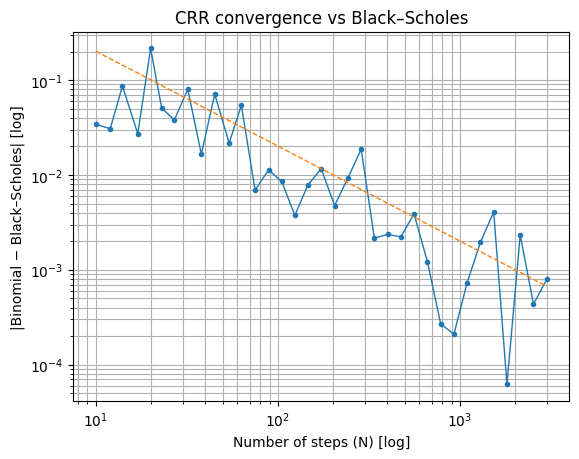

In [16]:
import math
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Normal CDF
# -------------------------
_INV_SQRT2 = 1.0 / math.sqrt(2.0)

def norm_cdf(x: float) -> float:
    """Standard normal CDF using erf; stable and fast."""
    return 0.5 * (1.0 + math.erf(x * _INV_SQRT2))

# -------------------------
# Black–Scholes price
# -------------------------
def bs_price(S0: float, K: float, r: float, T: float, vol: float, opttype: str = "C") -> float:
    """
    Black–Scholes price for European options, no dividends.
    opttype: 'C' (call) or 'P' (put)
    """
    if S0 <= 0 or K <= 0:
        raise ValueError("S0 and K must be > 0.")
    if T <= 0:
        # At expiry: value = intrinsic
        if opttype.upper().startswith("C"):
            return max(S0 - K, 0.0)
        return max(K - S0, 0.0)
    if vol <= 0:
        # Deterministic forward
        fwd = S0 * math.exp(r * T)
        discK = K * math.exp(-r * T)
        if opttype.upper().startswith("C"):
            return max(S0 - discK, 0.0) if fwd > K else 0.0
        return max(discK - S0, 0.0) if fwd < K else 0.0

    sqrtT = math.sqrt(T)
    vsqrtT = vol * sqrtT
    d1 = (math.log(S0 / K) + (r + 0.5 * vol * vol) * T) / vsqrtT
    d2 = d1 - vsqrtT
    disc = math.exp(-r * T)

    if opttype.upper().startswith("C"):
        return S0 * norm_cdf(d1) - K * disc * norm_cdf(d2)
    else:
        return K * disc * norm_cdf(-d2) - S0 * norm_cdf(-d1)

# -------------------------
# Convergence experiment
# -------------------------
# Choose a better N grid: denser at small N, fewer points at big N
Ns = np.unique(np.round(np.logspace(math.log10(10), math.log10(3000), 35)).astype(int))

prices = []
for N in Ns:
    u, d = crr_up_down(vol, T / N)
    prices.append(binomial_option_price_npv(S0, K, T, r, int(N), u, d, opttype, optclass))

bs = bs_price(S0, K, r, T, vol, opttype)
errors = np.abs(np.array(prices) - bs)

# Avoid log(0) without ruining scale
eps = np.finfo(float).tiny
errors_for_log = np.maximum(errors, eps)

# -------------------------
# Plot
# -------------------------
plt.figure()
plt.plot(Ns, errors_for_log, marker="o", linewidth=1, markersize=3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of steps (N) [log]")
plt.ylabel("|Binomial − Black–Scholes| [log]")
plt.title("CRR convergence vs Black–Scholes")

# Optional: add a reference slope line (visual guide)
# Choose a point and draw ~1/N line through it
ref_idx = len(Ns) // 2
refN = Ns[ref_idx]
refE = errors_for_log[ref_idx]
plt.plot(Ns, refE * (refN / Ns), linestyle="--", linewidth=1)  # ~O(1/N)

plt.grid(True, which="both")
plt.show()


## Stock Data

In [17]:
stock_data = collections.defaultdict(dict)

sp_tickers = pd.read_csv('./data/sp500_companies.csv', sep=',')
sp_tickers = np.array(sp_tickers['Symbol'].tolist()[:10])

for ticker in sp_tickers:
    yf_icker = yf.Ticker(ticker)
    try:
        options = yf_icker.options
        
        for exp in options:
            opt = yf_icker.option_chain(exp)
            calls = opt.calls
            puts = opt.puts
            
            stock_data[ticker][exp] = {
                'calls': calls,
                'puts': puts
            }
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

stock_data["AAPL"]

{'2026-02-02': {'calls':          contractSymbol             lastTradeDate  strike  lastPrice    bid  \
  0   AAPL260202C00175000 2026-01-30 15:19:49+00:00   175.0      82.40  88.30   
  1   AAPL260202C00180000 2026-01-30 19:50:36+00:00   180.0      78.09  83.40   
  2   AAPL260202C00190000 2026-01-30 17:18:14+00:00   190.0      64.70  73.30   
  3   AAPL260202C00205000 2026-01-29 20:18:44+00:00   205.0      53.28  58.30   
  4   AAPL260202C00210000 2026-01-26 17:10:17+00:00   210.0      45.07  53.40   
  5   AAPL260202C00215000 2026-01-30 20:49:00+00:00   215.0      45.50  48.30   
  6   AAPL260202C00220000 2026-01-30 19:14:34+00:00   220.0      37.52  43.40   
  7   AAPL260202C00225000 2026-01-30 20:43:15+00:00   225.0      35.25  38.30   
  8   AAPL260202C00230000 2026-02-02 15:06:25+00:00   230.0      33.60  33.40   
  9   AAPL260202C00232500 2026-01-30 20:30:51+00:00   232.5      26.95  30.80   
  10  AAPL260202C00235000 2026-01-30 20:31:40+00:00   235.0      25.07  28.30   
  11 

In [18]:
stock_data["AAPL"]["2026-02-02"]["calls"]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL260202C00175000,2026-01-30 15:19:49+00:00,175.0,82.40,88.30,90.55,0.000000,0.000000,10.0,10,5.031254,True,REGULAR,USD
1,AAPL260202C00180000,2026-01-30 19:50:36+00:00,180.0,78.09,83.40,85.80,0.000000,0.000000,1.0,0,4.863285,True,REGULAR,USD
2,AAPL260202C00190000,2026-01-30 17:18:14+00:00,190.0,64.70,73.30,75.85,0.000000,0.000000,1.0,2,4.277348,True,REGULAR,USD
3,AAPL260202C00205000,2026-01-29 20:18:44+00:00,205.0,53.28,58.30,60.85,0.000000,0.000000,NaN,2,3.461915,True,REGULAR,USD
4,AAPL260202C00210000,2026-01-26 17:10:17+00:00,210.0,45.07,53.40,55.65,0.000000,0.000000,NaN,1,3.173830,True,REGULAR,USD
5,AAPL260202C00215000,2026-01-30 20:49:00+00:00,215.0,45.50,48.30,50.85,0.000000,0.000000,6.0,5,2.938479,True,REGULAR,USD
6,AAPL260202C00220000,2026-01-30 19:14:34+00:00,220.0,37.52,43.40,45.10,0.000000,0.000000,62.0,13,2.527347,True,REGULAR,USD
7,AAPL260202C00225000,2026-01-30 20:43:15+00:00,225.0,35.25,38.30,40.70,0.000000,0.000000,157.0,131,2.391606,True,REGULAR,USD
8,AAPL260202C00230000,2026-02-02 15:06:25+00:00,230.0,33.60,33.40,35.60,4.139999,14.052952,1.0,9,2.138188,True,REGULAR,USD
9,AAPL260202C00232500,2026-01-30 20:30:51+00:00,232.5,26.95,30.80,32.90,0.000000,0.000000,2.0,1,1.952637,True,REGULAR,USD


## Implied Volatility IV